In [109]:
%matplotlib notebook
import cvxpy as cp
import dccp
import torch
import numpy as np
from cvxpylayers.torch import CvxpyLayer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import svm
from sklearn.metrics import zero_one_loss, confusion_matrix
from scipy.io import arff
import pandas as pd
import time
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import matplotlib.patches as mpatches
import json
import random
import math
import os, psutil
from datetime import datetime

torch.set_default_dtype(torch.float64)
torch.manual_seed(0)
np.random.seed(0)

XDIM = 11
COST = 1/XDIM
TRAIN_SLOPE = 1
EVAL_SLOPE = 5
X_LOWER_BOUND = -10
X_UPPER_BOUND = 10

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Utils

In [110]:
def split_data(X, Y, percentage):
    num_val = int(len(X)*percentage)
    return X[num_val:], Y[num_val:], X[:num_val], Y[:num_val]

def shuffle(X, Y):
    data = torch.cat((X, Y), 1)
    data = data[torch.randperm(data.size()[0])]
    X = data[:, :2]
    Y = data[:, 2]
    return X, Y

def conf_mat(Y1, Y2):
    num_of_samples = len(Y1)
    mat = confusion_matrix(Y1, Y2, labels=[-1, 1])*100/num_of_samples
    acc = np.trace(mat)
    return mat, acc

def calc_accuracy(Y, Ypred):
    num = len(Y)
    temp = Y - Ypred
    acc = len(temp[temp == 0])*1./num
    return acc



# Visualization

In [111]:
def visualize_data2D(X, Y):
    if not XDIM == 2:
        return
    
    Xpos = X[Y == 1]
    Xneg = X[Y == -1]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(Xpos[:, 0], Xpos[:, 1], marker='+', color='green')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], marker='_', color='purple')
    plt.show()
    
def visualize_weights(w1, b1, w2, b2):
    fig = plt.figure()
    plt.bar(np.arange(XDIM + 1), np.append(w1, b1), color='b', alpha=0.5)
    plt.bar(np.arange(XDIM + 1), np.append(w2, b2), color='r', alpha=0.5)
    plt.show()
    
def visualize_data3D(X, Y):
    if not XDIM == 3:
        return
    
    Xpos = X[Y == 1][:100]
    Xneg = X[Y == -1][:100]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(Xpos[:, 0], Xpos[:, 1], Xpos[:, 2], marker='+', color='green')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], Xneg[:, 2], marker='_', color='purple')
    plt.show()
    
def visualize_data2D(X, Y):
    if not XDIM == 2:
        return
    
    Xpos = X[Y == 1]
    Xneg = X[Y == -1]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(Xpos[:, 0], Xpos[:, 1], marker='+', color='green')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], marker='_', color='purple')
    plt.show()
    
def visualize_data(X, Y):
    if XDIM == 2:
        visualize_data2D(X, Y)
    else:
        visualize_data3D(X, Y)
    
def visualize_strategic_data3D(Xval, Xval_opt, Yval, w_non_strategic, b_non_strategic, w_strategic, b_strategic):
    if not XDIM == 3:
        return

    Xpos = Xval[Yval == 1][:50]
    Xneg = Xval[Yval == -1][:50]
    XposOpt = Xval_opt[Yval == 1][:50]
    XnegOpt = Xval_opt[Yval == -1][:50]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(Xpos[:, 0], Xpos[:, 1], Xpos[:, 2], marker='+', color='blue')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], Xneg[:, 2], marker='_', color='blue')

    ax.scatter(XposOpt[:, 0], XposOpt[:, 1], XposOpt[:, 2], marker='+', color='red')
    ax.scatter(XnegOpt[:, 0], XnegOpt[:, 1], XnegOpt[:, 2], marker='_', color='red')

    range_arr = torch.arange(-2, 2 + 1)
    xx, yy = torch.meshgrid(range_arr, range_arr)
    z = (-w_non_strategic[0] * xx - w_non_strategic[1] * yy - b_non_strategic) * 1. /w_non_strategic[2]
    ax.plot_surface(xx.numpy(), yy.numpy(), z.numpy(), alpha=0.2, color='blue')

    xx, yy = torch.meshgrid(range_arr, range_arr)
    z = (-w_strategic[0] * xx - w_strategic[1] * yy - b_strategic) * 1. /w_strategic[2]
    ax.plot_surface(xx.numpy(), yy.numpy(), z.numpy(), alpha=0.2, color='red')
#     ax.set_xlim3d(-1.2, 1.2)
#     ax.set_ylim3d(-1.2, 1.2)
#     ax.set_zlim3d(-1.2, 1.2)
#     ax.view_init(25, 45)
#     plt.savefig('plots/simple_strategic_classification.pdf', format='pdf')
#     plt.savefig('plots/simple_strategic_classification.eps', format='eps')
#     plt.savefig('plots/simple_strategic_classification.png', format='png')
    plt.show()

def visualize_strategic_data2D(Xval, Xval_opt, Yval, w_non_strategic, b_non_strategic, w_strategic, b_strategic):
    if not XDIM == 2:
        return

    Xpos = Xval[Yval == 1][:50]
    Xneg = Xval[Yval == -1][:50]
    XposOpt = Xval_opt[Yval == 1][:50]
    XnegOpt = Xval_opt[Yval == -1][:50]

    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.scatter(Xpos[:, 0], Xpos[:, 1], marker='+', color='blue')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], marker='_', color='blue')

    ax.scatter(XposOpt[:, 0], XposOpt[:, 1], marker='+', color='red')
    ax.scatter(XnegOpt[:, 0], XnegOpt[:, 1], marker='_', color='red')

    range_arr = torch.arange(-0.5, 2 + 1)
    xx = torch.meshgrid(range_arr)[0]
    z = (-w_non_strategic[0] * xx - b_non_strategic) * 1. /w_non_strategic[1]
    ax.plot(xx.detach().numpy(), z.detach().numpy(), alpha=0.2, color='blue')

    xx = torch.meshgrid(range_arr)[0]
    z = (-w_strategic[0] * xx - b_strategic) * 1. /w_strategic[1]
    ax.plot(xx.detach().numpy(), z.detach().numpy(), alpha=0.2, color='red')

    plt.show()
    
def visualize_strategic_data(Xval, Xval_opt, Yval, w_non_strategic, b_non_strategic, w_strategic, b_strategic):
    if XDIM == 2:
        visualize_strategic_data2D(Xval, Xval_opt, Yval, w_non_strategic, b_non_strategic, w_strategic, b_strategic)
    else:
        visualize_strategic_data3D(Xval, Xval_opt, Yval, w_non_strategic, b_non_strategic, w_strategic, b_strategic)
        
def visualize_training_errors(train_errors, val_errors):
    fig = plt.figure()
    train_patch, = plt.plot(torch.arange(len(train_errors)), np.mean(train_errors, axis=1), color='blue', label="train")
    val_patch, = plt.plot(torch.arange(len(val_errors)), val_errors, color='orange', label="validation")
    plt.legend(handles=[train_patch, val_patch])

    plt.show()
    
def visualize_training_losses(train_losses, val_losses):
    fig = plt.figure()
    train_patch, = plt.plot(torch.arange(len(train_losses)), np.mean(train_losses, axis=1), color='blue', label="train")
    val_patch, = plt.plot(torch.arange(len(val_losses)), val_losses, color='orange', label="validation")
    plt.legend(handles=[train_patch, val_patch])
    
    plt.show()

# Dataset

In [112]:
def gen_custom_data(N, pos_ranges, neg_ranges):
    """
    pos_ranges: a tuple of tensors of length XDIM.
    (scales tensor, offsets tensor)
    """
    torch.manual_seed(0)
    np.random.seed(0)
    pos_samples_num = N//2
    neg_samples_num = N - pos_samples_num
    posX = torch.rand((pos_samples_num, XDIM))*pos_ranges[0] + pos_ranges[1]
    negX = torch.rand((neg_samples_num, XDIM))*neg_ranges[0] + neg_ranges[1]
    
    X = torch.cat((posX, negX), 0)
    Y = torch.unsqueeze(torch.cat((torch.ones(len(posX)), -torch.ones(len(negX))), 0), 1)

    X, Y = shuffle(X, Y)
    return X, Y

def load_credit_default_data():
    torch.manual_seed(0)
    np.random.seed(0)
    url = 'https://raw.githubusercontent.com/ustunb/actionable-recourse/master/examples/paper/data/credit_processed.csv'
    df = pd.read_csv(url)
    df["NoDefaultNextMonth"].replace({0: -1}, inplace=True)
    df = df.sample(frac=1).reset_index(drop=True)

    df = df.drop(['Married', 'Single', 'Age_lt_25', 'Age_in_25_to_40', 'Age_in_40_to_59', 'Age_geq_60'], axis = 1)

    scaler = StandardScaler()
    df.loc[:, df.columns != "NoDefaultNextMonth"] = scaler.fit_transform(df.drop("NoDefaultNextMonth", axis=1))

    fraud_df = df.loc[df["NoDefaultNextMonth"] == -1]
    non_fraud_df = df.loc[df["NoDefaultNextMonth"] == 1][:6636]

    normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

    # Shuffle dataframe rows
    df = normal_distributed_df.sample(frac=1).reset_index(drop=True)

    Y, X = df.iloc[:, 0].values, df.iloc[:, 1:].values
    return torch.from_numpy(X), torch.from_numpy(Y)

    
def gen_sklearn_data(N, informative_frac=1, shift_range=1, scale_range=1, noise_frac=0.01):
    torch.manual_seed(0)
    np.random.seed(0)
    n_informative = int(informative_frac*XDIM)
    n_redundant = XDIM - n_informative
    shift_arr = shift_range*np.random.randn(XDIM)
    scale_arr = scale_range*np.random.randn(XDIM)
    X, Y = make_classification(n_samples=N, n_features=XDIM, n_informative=n_informative, n_redundant=n_redundant,
                               flip_y=noise_frac, shift=shift_arr, scale=scale_arr, random_state=0)
    Y[Y == 0] = -1
    return torch.from_numpy(X), torch.from_numpy(Y)

def gen_custom_normal_data(N, pos_mean, pos_std, neg_mean, neg_std):
    torch.manual_seed(0)
    np.random.seed(0)
    pos_samples_num = N//2
    neg_samples_num = N - pos_samples_num
    posX = torch.randn((pos_samples_num, XDIM))*pos_std + pos_mean
    negX = torch.randn((neg_samples_num, XDIM))*neg_std + neg_mean
    
    X = torch.cat((posX, negX), 0)
    Y = torch.unsqueeze(torch.cat((torch.ones(len(posX)), -torch.ones(len(negX))), 0), 1)

    X, Y = shuffle(X, Y)
    return X, Y


# CCP classes

In [113]:
class CCP:
    def __init__(self, x_dim, funcs):
        self.f_derivative = funcs["f_derivative"]
        self.g = funcs["g"]
        self.c = funcs["c"]
        
        self.x = cp.Variable(x_dim)
        self.xt = cp.Parameter(x_dim)
        self.r = cp.Parameter(x_dim)
        self.w = cp.Parameter(x_dim)
        self.b = cp.Parameter(1)
        self.slope = cp.Parameter(1)

        target = self.x@self.f_derivative(self.xt, self.w, self.b, self.slope)-self.g(self.x, self.w, self.b, self.slope)-self.c(self.x, self.r)
        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND]
        self.prob = cp.Problem(cp.Maximize(target), constraints)
        
    def ccp(self, r):
        """
        numpy to numpy
        """
        self.xt.value = r
        self.r.value = r
        result = self.prob.solve()
        diff = np.linalg.norm(self.xt.value - self.x.value)
        cnt = 0
        while diff > 0.0001 and cnt < 10:
            cnt += 1
            self.xt.value = self.x.value
            result = self.prob.solve()
            diff = np.linalg.norm(self.x.value - self.xt.value)
        return self.x.value
    
    def optimize_X(self, X, w, b, slope):
        """
        tensor to tensor
        """
        w = w.detach().numpy()
        b = b.detach().numpy()
        slope = np.full(1, slope)
        X = X.numpy()
        
        self.w.value = w
        self.b.value = b
        self.slope.value = slope
        
        return torch.stack([torch.from_numpy(self.ccp(x)) for x in X])

In [114]:
class DELTA():
    
    def __init__(self, x_dim, funcs):
        self.g = funcs["g"]
        self.c = funcs["c"]
        
        self.x = cp.Variable(x_dim)
        self.r = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.w = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.b = cp.Parameter(1, value = np.random.randn(1))
        self.f_der = cp.Parameter(x_dim, value = np.random.randn(x_dim))

        target = self.x@self.f_der-self.g(self.x, self.w, self.b, TRAIN_SLOPE)-self.c(self.x, self.r)
        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND]
        objective = cp.Maximize(target)
        problem = cp.Problem(objective, constraints)
        self.layer = CvxpyLayer(problem, parameters=[self.r, self.w, self.b, self.f_der],
                                variables=[self.x])
        
        
    def optimize_X(self, X, w, b, F_DER):
        return self.layer(X, w, b, F_DER)[0]

# Gain & Cost functions

In [115]:
def score(x, w, b):
    return x@w + b

def f(x, w, b, slope):
    return 0.5*cp.norm(cp.hstack([1, (slope*score(x, w, b) + 1)]), 2)

def g(x, w, b, slope):
    return 0.5*cp.norm(cp.hstack([1, (slope*score(x, w, b) - 1)]), 2)

def c(x, r):
    return COST*cp.sum_squares(x-r)

def f_derivative(x, w, b, slope):
    return 0.5*cp.multiply(slope*((slope*score(x, w, b) + 1)/cp.sqrt((slope*score(x, w, b) + 1)**2 + 1)), w)

funcs = {"f": f, "g": g, "f_derivative": f_derivative, "c": c, "score": score}

# Data generation

In [116]:
# N = 400
X, Y = load_credit_default_data()
X, Y = X[:3000], Y[:3000]
print(len(X[0]))
assert(len(X[0]) == XDIM)
X, Y, Xval, Yval = split_data(X, Y, 0.5)
Xval, Yval, Xtest, Ytest = split_data(Xval, Yval, 0.5)

print("percent of positive samples: {}%".format(100 * len(Y[Y == 1]) / len(Y)))
visualize_data(X, Y)

11
percent of positive samples: 49.266666666666666%


# Model

In [117]:
class MyStrategicModel(torch.nn.Module):
    def __init__(self, x_dim, funcs, train_slope, eval_slope, strategic=False, lamb=0):
        torch.manual_seed(0)
        np.random.seed(0)
        super(MyStrategicModel, self).__init__()
        self.x_dim = x_dim
        self.train_slope, self.eval_slope = train_slope, eval_slope
        self.w = torch.nn.parameter.Parameter(math.sqrt(1/x_dim)*(1-2*torch.rand(x_dim, dtype=torch.float64, requires_grad=True)))
        self.b = torch.nn.parameter.Parameter(torch.rand(1, dtype=torch.float64, requires_grad=True))
        self.strategic = strategic
        self.lamb = lamb
        self.ccp = CCP(x_dim, funcs)
        self.delta = DELTA(x_dim, funcs)

    def forward(self, X, evaluation=False):
        if evaluation:
            XT = self.ccp.optimize_X(X, self.w, self.b, self.eval_slope)
            utility = self.calc_utility(X, XT, evaluation=True)
            X_opt = XT
        else:
            XT = self.ccp.optimize_X(X, self.w, self.b, self.train_slope)
            F_DER = self.get_f_ders(XT, self.train_slope)
            X_opt = self.delta.optimize_X(X, self.w, self.b, F_DER) # Xopt should equal to XT but we do it again for the gradients
            utility = self.calc_utility(X, X_opt, evaluation=False)
        
        if self.strategic:
            output = self.score(X_opt)
        else:
            output = self.score(X)        
        
        return output, utility
    
    def optimize_X(self, X, evaluation=False):
        slope = self.eval_slope if evaluation else self.train_slope
        return self.ccp.optimize_X(X, self.w, self.b, slope)
    
    def score(self, x):
        return x@self.w + self.b
    
    def get_f_ders(self, XT, slope):
        return torch.stack([0.5*slope*((slope*self.score(xt) + 1)/torch.sqrt((slope*self.score(xt) + 1)**2 + 1))*self.w for xt in XT])

    def evaluate(self, X, Y):
        scores, _ = self.forward(X, evaluation=True)
        Y_pred = torch.sign(scores)
        num = len(Y)
        temp = Y - Y_pred
        acc = len(temp[temp == 0])*1./num        
        return acc
    
    def calc_utility(self, X, X_opt, evaluation=False):
        """
        NOT GENERIC FOR f, g, c!!!
        """
        slope = self.eval_slope if evaluation else self.train_slope
        S = self.score(X_opt)
        gain = 0.5*(torch.sqrt((slope*S + 1)**2 + 1) - torch.sqrt((slope*S - 1)**2 + 1))
        cost = COST*torch.sum((X_opt-X)**2, dim=1)
        
        return torch.mean(gain - cost)
    
    def loss(self, Y, Y_pred, utility):
        if self.lamb > 0:
            return torch.mean(torch.clamp(1 - Y_pred * Y, min=0)) - self.lamb*utility
        else:
            return torch.mean(torch.clamp(1 - Y_pred * Y, min=0))
        
    
    def save_model(self, X, Y, Xval, Yval, Xtest, Ytest, train_errors, val_errors, train_losses, val_losses, val_utilities, info, path, comment=None):
        if comment is not None:
            path += "_____" + comment
            
        filename = path + "/model.pt"
        if not os.path.exists(os.path.dirname(filename)):
            os.makedirs(os.path.dirname(filename))
        torch.save(self.state_dict(), filename)
        
        pd.DataFrame(X.numpy()).to_csv(path + '/X.csv')
        pd.DataFrame(Y.numpy()).to_csv(path + '/Y.csv')
        pd.DataFrame(Xval.numpy()).to_csv(path + '/Xval.csv')
        pd.DataFrame(Yval.numpy()).to_csv(path + '/Yval.csv')
        pd.DataFrame(Xval.numpy()).to_csv(path + '/Xtest.csv')
        pd.DataFrame(Yval.numpy()).to_csv(path + '/Ytest.csv')
        
        pd.DataFrame(np.array(train_errors)).to_csv(path + '/train_errors.csv')
        pd.DataFrame(np.array(val_errors)).to_csv(path + '/val_errors.csv')
        pd.DataFrame(np.array(train_losses)).to_csv(path + '/train_losses.csv')
        pd.DataFrame(np.array(val_losses)).to_csv(path + '/val_losses.csv')
        pd.DataFrame(np.array(val_utilities)).to_csv(path + '/val_utilities.csv')
        
        with open(path + "/info.txt", "w") as f:
            f.write(info)
    
    def load_model(self, filename):
        self.load_state_dict(torch.load(filename))
        self.eval()
    
    def fit(self, X, Y, Xval, Yval, Xtest, Ytest, opt, opt_kwargs={"lr":1e-3}, batch_size=128, epochs=100, verbose=False, callback=None, calc_train_errors=False, comment=None):
        train_dset = TensorDataset(X, Y)
        train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
        opt = opt(self.parameters(), **opt_kwargs)

        train_losses = []
        val_losses = []
        train_errors = []
        val_errors = []
        val_utilities = []
        
        best_val_error = 1
        consecutive_no_improvement = 0
        now = datetime.now()
        path = "C:/Users/sagil/Desktop/nir_project/models/utility/" + now.strftime("%d-%m-%Y_%H-%M-%S")

        total_time = time.time()
        for epoch in range(epochs):
            t1 = time.time()
            batch = 1
            train_losses.append([])
            train_errors.append([])
            for Xbatch, Ybatch in train_loader:
                opt.zero_grad()
                Ybatch_pred, utility = self.forward(Xbatch)
                l = self.loss(Ybatch, Ybatch_pred, utility)
                l.backward()
                opt.step()
                train_losses[-1].append(l.item())
                if calc_train_errors:
                    with torch.no_grad():
                        e = self.evaluate(Xbatch, Ybatch)
                        train_errors[-1].append(1-e)
                if verbose:
                    print("batch %03d / %03d | loss: %3.5f | utility: %3.5f" %
                          (batch, len(train_loader), np.mean(train_losses[-1]), utility))
                batch += 1
                if callback is not None:
                    callback()

            with torch.no_grad():
                Yval_pred, val_utility = self.forward(Xval , evaluation=True)
                val_utility = val_utility.item()
                val_loss = self.loss(Yval, Yval_pred, val_utility).item()
                val_losses.append(val_loss)
                val_error = 1-self.evaluate(Xval, Yval)
                val_errors.append(val_error)
                val_utilities.append(val_utility)
                if val_error < best_val_error:
                    consecutive_no_improvement = 0
                    best_val_error = val_error
                    if self.strategic:
                        info = "training time in seconds: {}\nepoch: {}\nbatch size: {}\ntrain slope: {}\neval slope: {}\nlearning rate: {}\nvalidation loss: {}\nvalidation error: {}\nutility: {}".format(
                        time.time()-total_time, epoch, batch_size, self.train_slope, self.eval_slope, opt_kwargs["lr"], val_loss, val_error, val_utility)
                        self.save_model(X, Y, Xval, Yval, Xtest, Ytest, train_errors, val_errors, train_losses, val_losses, val_utilities, info, path, comment)
                        print("model saved!")
                else:
                    consecutive_no_improvement += 1
                    if consecutive_no_improvement >= 4:
                        break
                
            t2 = time.time()
            if verbose:
                print("----- epoch %03d / %03d | time: %03d sec | loss: %3.5f | utility: %3.5f | err: %3.5f" % (epoch + 1, epochs, t2-t1, val_losses[-1], val_utilities[-1], val_errors[-1]))
        print("training time: {} seconds".format(time.time()-total_time)) 
        return train_errors, val_errors, train_losses, val_losses

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Train

In [120]:
EPOCHS = 10
BATCH_SIZE = 64

x_dim = XDIM

# # non-strategic classification
# print("---------- training non-strategically----------")
# non_strategic_model = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, strategic=False)

# fit_res_non_strategic = non_strategic_model.fit(X, Y, Xval, Yval, Xtest, Ytest,
#                                 opt=torch.optim.Adam, opt_kwargs={"lr": 5*(1e-2)},
#                                 batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True, calc_train_errors=False)


# strategic_model = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, strategic=True, lamb=10)

# fit_res_strategic = strategic_model.fit(X, Y, Xval, Yval, Xtest, Ytest,
#                                 opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
#                                 batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True, calc_train_errors=False,
#                                 comment="utility_default")


# lambda_range = torch.logspace(start=-0.4, end=-0.2, steps=10)
lambda_range = torch.arange(0.50921, 0.5093, 0.00002)
print(lambda_range)
for lamb in lambda_range:

    # strategic classification
    print("---------- training strategically----------")
    print("lambda: ", lamb.item())
    strategic_model = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, strategic=True, lamb=lamb)

    fit_res_strategic = strategic_model.fit(X, Y, Xval, Yval, Xtest, Ytest,
                                    opt=torch.optim.Adam, opt_kwargs={"lr": 5*(1e-2)},
                                    batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True, calc_train_errors=False,
                                    comment="utility_" + str(lamb.item()))

    

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix

tensor([0.5092, 0.5092, 0.5093, 0.5093, 0.5093])
---------- training strategically----------
lambda:  0.50921
batch 001 / 024 | loss: 0.64009 | utility: 0.34401
batch 002 / 024 | loss: 0.71321 | utility: 0.43313
batch 003 / 024 | loss: 0.69744 | utility: 0.47862
batch 004 / 024 | loss: 0.70412 | utility: 0.50905
batch 005 / 024 | loss: 0.74470 | utility: 0.44587
batch 006 / 024 | loss: 0.74547 | utility: 0.47644
batch 007 / 024 | loss: 0.75639 | utility: 0.40600
batch 008 / 024 | loss: 0.74481 | utility: 0.40807
batch 009 / 024 | loss: 0.75285 | utility: 0.37149
batch 010 / 024 | loss: 0.74755 | utility: 0.33809
batch 011 / 024 | loss: 0.73015 | utility: 0.27690
batch 012 / 024 | loss: 0.73392 | utility: 0.28286
batch 013 / 024 | loss: 0.72675 | utility: 0.39800
batch 014 / 024 | loss: 0.72833 | utility: 0.22206
batch 015 / 024 | loss: 0.72511 | utility: 0.25626
batch 016 / 024 | loss: 0.72382 | utility: 0.23553
batch 017 / 024 | loss: 0.72496 | utility: 0.26337
batch 018 / 024 | loss:

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


----- epoch 004 / 010 | time: 242 sec | loss: 0.46108 | utility: 0.57862 | err: 0.38267
batch 001 / 024 | loss: 0.78361 | utility: 0.28060
batch 002 / 024 | loss: 0.71137 | utility: 0.32763
batch 003 / 024 | loss: 0.75009 | utility: 0.22151
batch 004 / 024 | loss: 0.66364 | utility: 0.28513
batch 005 / 024 | loss: 0.67046 | utility: 0.23328
batch 006 / 024 | loss: 0.65161 | utility: 0.29597
batch 007 / 024 | loss: 0.65554 | utility: 0.23398
batch 008 / 024 | loss: 0.64275 | utility: 0.31441
batch 009 / 024 | loss: 0.65850 | utility: 0.26605
batch 010 / 024 | loss: 0.64627 | utility: 0.22904
batch 011 / 024 | loss: 0.64555 | utility: 0.29628
batch 012 / 024 | loss: 0.65680 | utility: 0.24759
batch 013 / 024 | loss: 0.64739 | utility: 0.22264
batch 014 / 024 | loss: 0.64475 | utility: 0.24197
batch 015 / 024 | loss: 0.64740 | utility: 0.18418
batch 016 / 024 | loss: 0.65308 | utility: 0.18664
batch 017 / 024 | loss: 0.64667 | utility: 0.31583
batch 018 / 024 | loss: 0.64630 | utility: 0.

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 024 | loss: 0.64008 | utility: 0.34401
batch 002 / 024 | loss: 0.71321 | utility: 0.43313
batch 003 / 024 | loss: 0.69743 | utility: 0.47862
batch 004 / 024 | loss: 0.70411 | utility: 0.50905
batch 005 / 024 | loss: 0.74470 | utility: 0.44587
batch 006 / 024 | loss: 0.74546 | utility: 0.47644
batch 007 / 024 | loss: 0.75638 | utility: 0.40601
batch 008 / 024 | loss: 0.74481 | utility: 0.40809
batch 009 / 024 | loss: 0.75284 | utility: 0.37151
batch 010 / 024 | loss: 0.74755 | utility: 0.33811
batch 011 / 024 | loss: 0.73015 | utility: 0.27692
batch 012 / 024 | loss: 0.73392 | utility: 0.28288
batch 013 / 024 | loss: 0.72675 | utility: 0.39802
batch 014 / 024 | loss: 0.72833 | utility: 0.22208
batch 015 / 024 | loss: 0.72511 | utility: 0.25628
batch 016 / 024 | loss: 0.72382 | utility: 0.23556
batch 017 / 024 | loss: 0.72495 | utility: 0.26340
batch 018 / 024 | loss: 0.73602 | utility: 0.23111
batch 019 / 024 | loss: 0.73776 | utility: 0.27652
batch 020 / 024 | loss: 0.73222

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


model saved!
----- epoch 001 / 010 | time: 253 sec | loss: 0.46247 | utility: 0.59672 | err: 0.37867
batch 001 / 024 | loss: 0.60519 | utility: 0.30688
batch 002 / 024 | loss: 0.67265 | utility: 0.24280
batch 003 / 024 | loss: 0.67578 | utility: 0.22422
batch 004 / 024 | loss: 0.66109 | utility: 0.23411
batch 005 / 024 | loss: 0.67241 | utility: 0.37257
batch 006 / 024 | loss: 0.69677 | utility: 0.23331
batch 007 / 024 | loss: 0.68988 | utility: 0.22583
batch 008 / 024 | loss: 0.67376 | utility: 0.28545
batch 009 / 024 | loss: 0.66892 | utility: 0.26194
batch 010 / 024 | loss: 0.66444 | utility: 0.24236
batch 011 / 024 | loss: 0.66897 | utility: 0.21991
batch 012 / 024 | loss: 0.66697 | utility: 0.22091
batch 013 / 024 | loss: 0.66404 | utility: 0.24255
batch 014 / 024 | loss: 0.65915 | utility: 0.27706
batch 015 / 024 | loss: 0.65965 | utility: 0.10364
batch 016 / 024 | loss: 0.65808 | utility: 0.27647
batch 017 / 024 | loss: 0.65901 | utility: 0.26018
batch 018 / 024 | loss: 0.65608 

batch 005 / 024 | loss: 0.67691 | utility: 0.14338
batch 006 / 024 | loss: 0.67489 | utility: 0.11397
batch 007 / 024 | loss: 0.66082 | utility: 0.22129
batch 008 / 024 | loss: 0.66287 | utility: 0.07402
batch 009 / 024 | loss: 0.68110 | utility: 0.12738
batch 010 / 024 | loss: 0.67097 | utility: 0.12893
batch 011 / 024 | loss: 0.64834 | utility: 0.21111
batch 012 / 024 | loss: 0.63357 | utility: 0.19499
batch 013 / 024 | loss: 0.63061 | utility: 0.20213
batch 014 / 024 | loss: 0.64322 | utility: 0.18761
batch 015 / 024 | loss: 0.64222 | utility: 0.22668
batch 016 / 024 | loss: 0.63814 | utility: 0.20724
batch 017 / 024 | loss: 0.63159 | utility: 0.19551
batch 018 / 024 | loss: 0.63565 | utility: 0.10857
batch 019 / 024 | loss: 0.63957 | utility: 0.20759
batch 020 / 024 | loss: 0.64235 | utility: 0.07403
batch 021 / 024 | loss: 0.64852 | utility: 0.10133
batch 022 / 024 | loss: 0.65078 | utility: 0.13019
batch 023 / 024 | loss: 0.64924 | utility: 0.17867
batch 024 / 024 | loss: 0.65567

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 024 | loss: 0.64007 | utility: 0.34401
batch 002 / 024 | loss: 0.71320 | utility: 0.43313
batch 003 / 024 | loss: 0.69742 | utility: 0.47862
batch 004 / 024 | loss: 0.70410 | utility: 0.50905
batch 005 / 024 | loss: 0.74469 | utility: 0.44588
batch 006 / 024 | loss: 0.74545 | utility: 0.47645
batch 007 / 024 | loss: 0.75638 | utility: 0.40602
batch 008 / 024 | loss: 0.74480 | utility: 0.40810
batch 009 / 024 | loss: 0.75283 | utility: 0.37152
batch 010 / 024 | loss: 0.74754 | utility: 0.33812
batch 011 / 024 | loss: 0.73014 | utility: 0.27694
batch 012 / 024 | loss: 0.73391 | utility: 0.28290
batch 013 / 024 | loss: 0.72675 | utility: 0.39803
batch 014 / 024 | loss: 0.72832 | utility: 0.22210
batch 015 / 024 | loss: 0.72510 | utility: 0.25630
batch 016 / 024 | loss: 0.72381 | utility: 0.23558
batch 017 / 024 | loss: 0.72495 | utility: 0.26343
batch 018 / 024 | loss: 0.73601 | utility: 0.23113
batch 019 / 024 | loss: 0.73775 | utility: 0.27655
batch 020 / 024 | loss: 0.73222

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


batch 012 / 024 | loss: 0.65617 | utility: 0.24988
batch 013 / 024 | loss: 0.64639 | utility: 0.22491
batch 014 / 024 | loss: 0.64327 | utility: 0.24596
batch 015 / 024 | loss: 0.64603 | utility: 0.18331
batch 016 / 024 | loss: 0.65167 | utility: 0.18260
batch 017 / 024 | loss: 0.64517 | utility: 0.30964
batch 018 / 024 | loss: 0.64455 | utility: 0.23610
batch 019 / 024 | loss: 0.64711 | utility: 0.23700
batch 020 / 024 | loss: 0.65362 | utility: 0.24395
batch 021 / 024 | loss: 0.65824 | utility: 0.21000
batch 022 / 024 | loss: 0.66199 | utility: 0.18659
batch 023 / 024 | loss: 0.65857 | utility: 0.26268
batch 024 / 024 | loss: 0.65551 | utility: 0.32407
model saved!
----- epoch 005 / 010 | time: 371 sec | loss: 0.47151 | utility: 0.56248 | err: 0.37333
batch 001 / 024 | loss: 0.62520 | utility: 0.25368
batch 002 / 024 | loss: 0.57231 | utility: 0.32560
batch 003 / 024 | loss: 0.61993 | utility: 0.20809
batch 004 / 024 | loss: 0.62892 | utility: 0.28821
batch 005 / 024 | loss: 0.63630 

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 024 | loss: 0.64007 | utility: 0.34401
batch 002 / 024 | loss: 0.71319 | utility: 0.43313
batch 003 / 024 | loss: 0.69741 | utility: 0.47862
batch 004 / 024 | loss: 0.70410 | utility: 0.50906
batch 005 / 024 | loss: 0.74468 | utility: 0.44588
batch 006 / 024 | loss: 0.74544 | utility: 0.47646
batch 007 / 024 | loss: 0.75637 | utility: 0.40603
batch 008 / 024 | loss: 0.74479 | utility: 0.40811
batch 009 / 024 | loss: 0.75283 | utility: 0.37154
batch 010 / 024 | loss: 0.74754 | utility: 0.33814
batch 011 / 024 | loss: 0.73013 | utility: 0.27696
batch 012 / 024 | loss: 0.73391 | utility: 0.28291
batch 013 / 024 | loss: 0.72674 | utility: 0.39805
batch 014 / 024 | loss: 0.72832 | utility: 0.22213
batch 015 / 024 | loss: 0.72510 | utility: 0.25632
batch 016 / 024 | loss: 0.72381 | utility: 0.23560
batch 017 / 024 | loss: 0.72494 | utility: 0.26345
batch 018 / 024 | loss: 0.73601 | utility: 0.23116
batch 019 / 024 | loss: 0.73775 | utility: 0.27658
batch 020 / 024 | loss: 0.73221

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


model saved!
----- epoch 001 / 010 | time: 246 sec | loss: 0.46243 | utility: 0.59679 | err: 0.37867
batch 001 / 024 | loss: 0.60517 | utility: 0.30697
batch 002 / 024 | loss: 0.67263 | utility: 0.24291
batch 003 / 024 | loss: 0.67577 | utility: 0.22435
batch 004 / 024 | loss: 0.66107 | utility: 0.23424
batch 005 / 024 | loss: 0.67239 | utility: 0.37267
batch 006 / 024 | loss: 0.69675 | utility: 0.23347
batch 007 / 024 | loss: 0.68986 | utility: 0.22599
batch 008 / 024 | loss: 0.67374 | utility: 0.28560
batch 009 / 024 | loss: 0.66890 | utility: 0.26210
batch 010 / 024 | loss: 0.66443 | utility: 0.24252
batch 011 / 024 | loss: 0.66896 | utility: 0.22012
batch 012 / 024 | loss: 0.66697 | utility: 0.22111
batch 013 / 024 | loss: 0.66403 | utility: 0.24273
batch 014 / 024 | loss: 0.65914 | utility: 0.27726
batch 015 / 024 | loss: 0.65964 | utility: 0.10389
batch 016 / 024 | loss: 0.65807 | utility: 0.27668
batch 017 / 024 | loss: 0.65900 | utility: 0.26041
batch 018 / 024 | loss: 0.65607 

batch 005 / 024 | loss: 0.67505 | utility: 0.12960
batch 006 / 024 | loss: 0.67311 | utility: 0.09892
batch 007 / 024 | loss: 0.65889 | utility: 0.21250
batch 008 / 024 | loss: 0.66057 | utility: 0.05722
batch 009 / 024 | loss: 0.67927 | utility: 0.11144
batch 010 / 024 | loss: 0.66957 | utility: 0.10895
batch 011 / 024 | loss: 0.64734 | utility: 0.19161
batch 012 / 024 | loss: 0.63252 | utility: 0.17338
batch 013 / 024 | loss: 0.62907 | utility: 0.17780
batch 014 / 024 | loss: 0.64098 | utility: 0.16376
batch 015 / 024 | loss: 0.64013 | utility: 0.19863
batch 016 / 024 | loss: 0.63685 | utility: 0.18002
batch 017 / 024 | loss: 0.63046 | utility: 0.17491
batch 018 / 024 | loss: 0.63429 | utility: 0.09789
batch 019 / 024 | loss: 0.63834 | utility: 0.20168
batch 020 / 024 | loss: 0.64105 | utility: 0.07025
batch 021 / 024 | loss: 0.64756 | utility: 0.09842
batch 022 / 024 | loss: 0.64969 | utility: 0.12501
batch 023 / 024 | loss: 0.64810 | utility: 0.16649
batch 024 / 024 | loss: 0.65365

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 024 | loss: 0.64006 | utility: 0.34401
batch 002 / 024 | loss: 0.71318 | utility: 0.43313
batch 003 / 024 | loss: 0.69741 | utility: 0.47862
batch 004 / 024 | loss: 0.70409 | utility: 0.50906
batch 005 / 024 | loss: 0.74467 | utility: 0.44589
batch 006 / 024 | loss: 0.74544 | utility: 0.47646
batch 007 / 024 | loss: 0.75636 | utility: 0.40604
batch 008 / 024 | loss: 0.74479 | utility: 0.40812
batch 009 / 024 | loss: 0.75282 | utility: 0.37155
batch 010 / 024 | loss: 0.74753 | utility: 0.33815
batch 011 / 024 | loss: 0.73013 | utility: 0.27697
batch 012 / 024 | loss: 0.73390 | utility: 0.28293
batch 013 / 024 | loss: 0.72674 | utility: 0.39807
batch 014 / 024 | loss: 0.72831 | utility: 0.22215
batch 015 / 024 | loss: 0.72509 | utility: 0.25634
batch 016 / 024 | loss: 0.72380 | utility: 0.23562
batch 017 / 024 | loss: 0.72494 | utility: 0.26348
batch 018 / 024 | loss: 0.73600 | utility: 0.23119
batch 019 / 024 | loss: 0.73774 | utility: 0.27661
batch 020 / 024 | loss: 0.73221

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


batch 001 / 024 | loss: 0.60517 | utility: 0.30702
batch 002 / 024 | loss: 0.67261 | utility: 0.24297
batch 003 / 024 | loss: 0.67576 | utility: 0.22441
batch 004 / 024 | loss: 0.66106 | utility: 0.23430
batch 005 / 024 | loss: 0.67238 | utility: 0.37272
batch 006 / 024 | loss: 0.69674 | utility: 0.23355
batch 007 / 024 | loss: 0.68985 | utility: 0.22607
batch 008 / 024 | loss: 0.67373 | utility: 0.28567
batch 009 / 024 | loss: 0.66889 | utility: 0.26218
batch 010 / 024 | loss: 0.66442 | utility: 0.24260
batch 011 / 024 | loss: 0.66896 | utility: 0.22022
batch 012 / 024 | loss: 0.66696 | utility: 0.22121
batch 013 / 024 | loss: 0.66403 | utility: 0.24282
batch 014 / 024 | loss: 0.65913 | utility: 0.27735
batch 015 / 024 | loss: 0.65964 | utility: 0.10402
batch 016 / 024 | loss: 0.65807 | utility: 0.27679
batch 017 / 024 | loss: 0.65900 | utility: 0.26053
batch 018 / 024 | loss: 0.65606 | utility: 0.30669
batch 019 / 024 | loss: 0.65807 | utility: 0.25552
batch 020 / 024 | loss: 0.65623

batch 007 / 024 | loss: 0.65880 | utility: 0.19914
batch 008 / 024 | loss: 0.66105 | utility: 0.04109
batch 009 / 024 | loss: 0.67898 | utility: 0.10038
batch 010 / 024 | loss: 0.66957 | utility: 0.09900
batch 011 / 024 | loss: 0.64752 | utility: 0.18316
batch 012 / 024 | loss: 0.63277 | utility: 0.17276
batch 013 / 024 | loss: 0.62976 | utility: 0.18418
batch 014 / 024 | loss: 0.64198 | utility: 0.17343
batch 015 / 024 | loss: 0.64085 | utility: 0.20951
batch 016 / 024 | loss: 0.63683 | utility: 0.19899
batch 017 / 024 | loss: 0.63025 | utility: 0.18373
batch 018 / 024 | loss: 0.63423 | utility: 0.10747
batch 019 / 024 | loss: 0.63804 | utility: 0.20577
batch 020 / 024 | loss: 0.64097 | utility: 0.08128
batch 021 / 024 | loss: 0.64713 | utility: 0.11411
batch 022 / 024 | loss: 0.64931 | utility: 0.14104
batch 023 / 024 | loss: 0.64768 | utility: 0.19052
batch 024 / 024 | loss: 0.65423 | utility: 0.25853
----- epoch 008 / 010 | time: 278 sec | loss: 0.49218 | utility: 0.43712 | err: 0.

In [93]:
utilities = []
accuracies = []
path = "C:/Users/sagil/Desktop/nir_project/models/utility/tradeoff_real3"
i = 0
for root,d_names,f_names in os.walk(path):
    if "val_utilities.csv" in f_names:
        i+=1
        print(i)
        model = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, strategic=True, lamb=lamb)
        model.load_model(root + '/model.pt')
        model.eval_slope = 5
        _, utility = model.forward(Xval, evaluation=True)
        utilities.append(utility.item())
        val_errors = pd.read_csv(root + '/val_errors.csv')
        acc = 1 - val_errors.values[-1][1]
        accuracies.append(acc)
        print(utilities)

print(utilities)
print(accuracies)
utilities.reverse()
accuracies.reverse()

1


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874]
2


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554]
3


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554, 0.03226070617939598]
4


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554, 0.03226070617939598, 0.03221654227439755]
5


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554, 0.03226070617939598, 0.03221654227439755, 0.032488657804636514]
6


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554, 0.03226070617939598, 0.03221654227439755, 0.032488657804636514, 0.033773630004129036]
7


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554, 0.03226070617939598, 0.03221654227439755, 0.032488657804636514, 0.033773630004129036, 0.034634551051072424]
8


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554, 0.03226070617939598, 0.03221654227439755, 0.032488657804636514, 0.033773630004129036, 0.034634551051072424, 0.035037586385642104]
9


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554, 0.03226070617939598, 0.03221654227439755, 0.032488657804636514, 0.033773630004129036, 0.034634551051072424, 0.035037586385642104, 0.0365634327421774]
10


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554, 0.03226070617939598, 0.03221654227439755, 0.032488657804636514, 0.033773630004129036, 0.034634551051072424, 0.035037586385642104, 0.0365634327421774, 0.037948416910130234]
11


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554, 0.03226070617939598, 0.03221654227439755, 0.032488657804636514, 0.033773630004129036, 0.034634551051072424, 0.035037586385642104, 0.0365634327421774, 0.037948416910130234, 0.03984909883655219]
12


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554, 0.03226070617939598, 0.03221654227439755, 0.032488657804636514, 0.033773630004129036, 0.034634551051072424, 0.035037586385642104, 0.0365634327421774, 0.037948416910130234, 0.03984909883655219, 0.042107944665129265]
13


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554, 0.03226070617939598, 0.03221654227439755, 0.032488657804636514, 0.033773630004129036, 0.034634551051072424, 0.035037586385642104, 0.0365634327421774, 0.037948416910130234, 0.03984909883655219, 0.042107944665129265, 0.045581620290505116]
14


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554, 0.03226070617939598, 0.03221654227439755, 0.032488657804636514, 0.033773630004129036, 0.034634551051072424, 0.035037586385642104, 0.0365634327421774, 0.037948416910130234, 0.03984909883655219, 0.042107944665129265, 0.045581620290505116, 0.047606955701604683]
15


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554, 0.03226070617939598, 0.03221654227439755, 0.032488657804636514, 0.033773630004129036, 0.034634551051072424, 0.035037586385642104, 0.0365634327421774, 0.037948416910130234, 0.03984909883655219, 0.042107944665129265, 0.045581620290505116, 0.047606955701604683, 0.047515796995185176]
16


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554, 0.03226070617939598, 0.03221654227439755, 0.032488657804636514, 0.033773630004129036, 0.034634551051072424, 0.035037586385642104, 0.0365634327421774, 0.037948416910130234, 0.03984909883655219, 0.042107944665129265, 0.045581620290505116, 0.047606955701604683, 0.047515796995185176, 0.049663596768488014]
17


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554, 0.03226070617939598, 0.03221654227439755, 0.032488657804636514, 0.033773630004129036, 0.034634551051072424, 0.035037586385642104, 0.0365634327421774, 0.037948416910130234, 0.03984909883655219, 0.042107944665129265, 0.045581620290505116, 0.047606955701604683, 0.047515796995185176, 0.049663596768488014, 0.05473842524131122]
18


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554, 0.03226070617939598, 0.03221654227439755, 0.032488657804636514, 0.033773630004129036, 0.034634551051072424, 0.035037586385642104, 0.0365634327421774, 0.037948416910130234, 0.03984909883655219, 0.042107944665129265, 0.045581620290505116, 0.047606955701604683, 0.047515796995185176, 0.049663596768488014, 0.05473842524131122, 0.06021455324329683]
19


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554, 0.03226070617939598, 0.03221654227439755, 0.032488657804636514, 0.033773630004129036, 0.034634551051072424, 0.035037586385642104, 0.0365634327421774, 0.037948416910130234, 0.03984909883655219, 0.042107944665129265, 0.045581620290505116, 0.047606955701604683, 0.047515796995185176, 0.049663596768488014, 0.05473842524131122, 0.06021455324329683, 0.0639730756192904]
20


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554, 0.03226070617939598, 0.03221654227439755, 0.032488657804636514, 0.033773630004129036, 0.034634551051072424, 0.035037586385642104, 0.0365634327421774, 0.037948416910130234, 0.03984909883655219, 0.042107944665129265, 0.045581620290505116, 0.047606955701604683, 0.047515796995185176, 0.049663596768488014, 0.05473842524131122, 0.06021455324329683, 0.0639730756192904, 0.12464671381289792]
21


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554, 0.03226070617939598, 0.03221654227439755, 0.032488657804636514, 0.033773630004129036, 0.034634551051072424, 0.035037586385642104, 0.0365634327421774, 0.037948416910130234, 0.03984909883655219, 0.042107944665129265, 0.045581620290505116, 0.047606955701604683, 0.047515796995185176, 0.049663596768488014, 0.05473842524131122, 0.06021455324329683, 0.0639730756192904, 0.12464671381289792, 0.10503753003053877]
22


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554, 0.03226070617939598, 0.03221654227439755, 0.032488657804636514, 0.033773630004129036, 0.034634551051072424, 0.035037586385642104, 0.0365634327421774, 0.037948416910130234, 0.03984909883655219, 0.042107944665129265, 0.045581620290505116, 0.047606955701604683, 0.047515796995185176, 0.049663596768488014, 0.05473842524131122, 0.06021455324329683, 0.0639730756192904, 0.12464671381289792, 0.10503753003053877, 0.0971747764869939]
23


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554, 0.03226070617939598, 0.03221654227439755, 0.032488657804636514, 0.033773630004129036, 0.034634551051072424, 0.035037586385642104, 0.0365634327421774, 0.037948416910130234, 0.03984909883655219, 0.042107944665129265, 0.045581620290505116, 0.047606955701604683, 0.047515796995185176, 0.049663596768488014, 0.05473842524131122, 0.06021455324329683, 0.0639730756192904, 0.12464671381289792, 0.10503753003053877, 0.0971747764869939, 0.2224378197951399]
24


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554, 0.03226070617939598, 0.03221654227439755, 0.032488657804636514, 0.033773630004129036, 0.034634551051072424, 0.035037586385642104, 0.0365634327421774, 0.037948416910130234, 0.03984909883655219, 0.042107944665129265, 0.045581620290505116, 0.047606955701604683, 0.047515796995185176, 0.049663596768488014, 0.05473842524131122, 0.06021455324329683, 0.0639730756192904, 0.12464671381289792, 0.10503753003053877, 0.0971747764869939, 0.2224378197951399, 0.263559105593155]
25


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554, 0.03226070617939598, 0.03221654227439755, 0.032488657804636514, 0.033773630004129036, 0.034634551051072424, 0.035037586385642104, 0.0365634327421774, 0.037948416910130234, 0.03984909883655219, 0.042107944665129265, 0.045581620290505116, 0.047606955701604683, 0.047515796995185176, 0.049663596768488014, 0.05473842524131122, 0.06021455324329683, 0.0639730756192904, 0.12464671381289792, 0.10503753003053877, 0.0971747764869939, 0.2224378197951399, 0.263559105593155, 0.6717842215461932]
26


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554, 0.03226070617939598, 0.03221654227439755, 0.032488657804636514, 0.033773630004129036, 0.034634551051072424, 0.035037586385642104, 0.0365634327421774, 0.037948416910130234, 0.03984909883655219, 0.042107944665129265, 0.045581620290505116, 0.047606955701604683, 0.047515796995185176, 0.049663596768488014, 0.05473842524131122, 0.06021455324329683, 0.0639730756192904, 0.12464671381289792, 0.10503753003053877, 0.0971747764869939, 0.2224378197951399, 0.263559105593155, 0.6717842215461932, 0.860691256602617]
27


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554, 0.03226070617939598, 0.03221654227439755, 0.032488657804636514, 0.033773630004129036, 0.034634551051072424, 0.035037586385642104, 0.0365634327421774, 0.037948416910130234, 0.03984909883655219, 0.042107944665129265, 0.045581620290505116, 0.047606955701604683, 0.047515796995185176, 0.049663596768488014, 0.05473842524131122, 0.06021455324329683, 0.0639730756192904, 0.12464671381289792, 0.10503753003053877, 0.0971747764869939, 0.2224378197951399, 0.263559105593155, 0.6717842215461932, 0.860691256602617, 0.9266212754851045]
28


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554, 0.03226070617939598, 0.03221654227439755, 0.032488657804636514, 0.033773630004129036, 0.034634551051072424, 0.035037586385642104, 0.0365634327421774, 0.037948416910130234, 0.03984909883655219, 0.042107944665129265, 0.045581620290505116, 0.047606955701604683, 0.047515796995185176, 0.049663596768488014, 0.05473842524131122, 0.06021455324329683, 0.0639730756192904, 0.12464671381289792, 0.10503753003053877, 0.0971747764869939, 0.2224378197951399, 0.263559105593155, 0.6717842215461932, 0.860691256602617, 0.9266212754851045, 0.9436518624532527]
29


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554, 0.03226070617939598, 0.03221654227439755, 0.032488657804636514, 0.033773630004129036, 0.034634551051072424, 0.035037586385642104, 0.0365634327421774, 0.037948416910130234, 0.03984909883655219, 0.042107944665129265, 0.045581620290505116, 0.047606955701604683, 0.047515796995185176, 0.049663596768488014, 0.05473842524131122, 0.06021455324329683, 0.0639730756192904, 0.12464671381289792, 0.10503753003053877, 0.0971747764869939, 0.2224378197951399, 0.263559105593155, 0.6717842215461932, 0.860691256602617, 0.9266212754851045, 0.9436518624532527, 0.9625297278532374]
30


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554, 0.03226070617939598, 0.03221654227439755, 0.032488657804636514, 0.033773630004129036, 0.034634551051072424, 0.035037586385642104, 0.0365634327421774, 0.037948416910130234, 0.03984909883655219, 0.042107944665129265, 0.045581620290505116, 0.047606955701604683, 0.047515796995185176, 0.049663596768488014, 0.05473842524131122, 0.06021455324329683, 0.0639730756192904, 0.12464671381289792, 0.10503753003053877, 0.0971747764869939, 0.2224378197951399, 0.263559105593155, 0.6717842215461932, 0.860691256602617, 0.9266212754851045, 0.9436518624532527, 0.9625297278532374, 0.20994612606911228]
31


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554, 0.03226070617939598, 0.03221654227439755, 0.032488657804636514, 0.033773630004129036, 0.034634551051072424, 0.035037586385642104, 0.0365634327421774, 0.037948416910130234, 0.03984909883655219, 0.042107944665129265, 0.045581620290505116, 0.047606955701604683, 0.047515796995185176, 0.049663596768488014, 0.05473842524131122, 0.06021455324329683, 0.0639730756192904, 0.12464671381289792, 0.10503753003053877, 0.0971747764869939, 0.2224378197951399, 0.263559105593155, 0.6717842215461932, 0.860691256602617, 0.9266212754851045, 0.9436518624532527, 0.9625297278532374, 0.20994612606911228, 0.2292404582233284]
32


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554, 0.03226070617939598, 0.03221654227439755, 0.032488657804636514, 0.033773630004129036, 0.034634551051072424, 0.035037586385642104, 0.0365634327421774, 0.037948416910130234, 0.03984909883655219, 0.042107944665129265, 0.045581620290505116, 0.047606955701604683, 0.047515796995185176, 0.049663596768488014, 0.05473842524131122, 0.06021455324329683, 0.0639730756192904, 0.12464671381289792, 0.10503753003053877, 0.0971747764869939, 0.2224378197951399, 0.263559105593155, 0.6717842215461932, 0.860691256602617, 0.9266212754851045, 0.9436518624532527, 0.9625297278532374, 0.20994612606911228, 0.2292404582233284, 0.2613048217196312]
33


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554, 0.03226070617939598, 0.03221654227439755, 0.032488657804636514, 0.033773630004129036, 0.034634551051072424, 0.035037586385642104, 0.0365634327421774, 0.037948416910130234, 0.03984909883655219, 0.042107944665129265, 0.045581620290505116, 0.047606955701604683, 0.047515796995185176, 0.049663596768488014, 0.05473842524131122, 0.06021455324329683, 0.0639730756192904, 0.12464671381289792, 0.10503753003053877, 0.0971747764869939, 0.2224378197951399, 0.263559105593155, 0.6717842215461932, 0.860691256602617, 0.9266212754851045, 0.9436518624532527, 0.9625297278532374, 0.20994612606911228, 0.2292404582233284, 0.2613048217196312, 0.3039290618993893]
34


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554, 0.03226070617939598, 0.03221654227439755, 0.032488657804636514, 0.033773630004129036, 0.034634551051072424, 0.035037586385642104, 0.0365634327421774, 0.037948416910130234, 0.03984909883655219, 0.042107944665129265, 0.045581620290505116, 0.047606955701604683, 0.047515796995185176, 0.049663596768488014, 0.05473842524131122, 0.06021455324329683, 0.0639730756192904, 0.12464671381289792, 0.10503753003053877, 0.0971747764869939, 0.2224378197951399, 0.263559105593155, 0.6717842215461932, 0.860691256602617, 0.9266212754851045, 0.9436518624532527, 0.9625297278532374, 0.20994612606911228, 0.2292404582233284, 0.2613048217196312, 0.3039290618993893, 0.2845521866114164]
35


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554, 0.03226070617939598, 0.03221654227439755, 0.032488657804636514, 0.033773630004129036, 0.034634551051072424, 0.035037586385642104, 0.0365634327421774, 0.037948416910130234, 0.03984909883655219, 0.042107944665129265, 0.045581620290505116, 0.047606955701604683, 0.047515796995185176, 0.049663596768488014, 0.05473842524131122, 0.06021455324329683, 0.0639730756192904, 0.12464671381289792, 0.10503753003053877, 0.0971747764869939, 0.2224378197951399, 0.263559105593155, 0.6717842215461932, 0.860691256602617, 0.9266212754851045, 0.9436518624532527, 0.9625297278532374, 0.20994612606911228, 0.2292404582233284, 0.2613048217196312, 0.3039290618993893, 0.2845521866114164, 0.6159741018915853]
36


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554, 0.03226070617939598, 0.03221654227439755, 0.032488657804636514, 0.033773630004129036, 0.034634551051072424, 0.035037586385642104, 0.0365634327421774, 0.037948416910130234, 0.03984909883655219, 0.042107944665129265, 0.045581620290505116, 0.047606955701604683, 0.047515796995185176, 0.049663596768488014, 0.05473842524131122, 0.06021455324329683, 0.0639730756192904, 0.12464671381289792, 0.10503753003053877, 0.0971747764869939, 0.2224378197951399, 0.263559105593155, 0.6717842215461932, 0.860691256602617, 0.9266212754851045, 0.9436518624532527, 0.9625297278532374, 0.20994612606911228, 0.2292404582233284, 0.2613048217196312, 0.3039290618993893, 0.2845521866114164, 0.6159741018915853, 0.7242358974044542]
37


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554, 0.03226070617939598, 0.03221654227439755, 0.032488657804636514, 0.033773630004129036, 0.034634551051072424, 0.035037586385642104, 0.0365634327421774, 0.037948416910130234, 0.03984909883655219, 0.042107944665129265, 0.045581620290505116, 0.047606955701604683, 0.047515796995185176, 0.049663596768488014, 0.05473842524131122, 0.06021455324329683, 0.0639730756192904, 0.12464671381289792, 0.10503753003053877, 0.0971747764869939, 0.2224378197951399, 0.263559105593155, 0.6717842215461932, 0.860691256602617, 0.9266212754851045, 0.9436518624532527, 0.9625297278532374, 0.20994612606911228, 0.2292404582233284, 0.2613048217196312, 0.3039290618993893, 0.2845521866114164, 0.6159741018915853, 0.7242358974044542, 0.7980448463045181]
38


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554, 0.03226070617939598, 0.03221654227439755, 0.032488657804636514, 0.033773630004129036, 0.034634551051072424, 0.035037586385642104, 0.0365634327421774, 0.037948416910130234, 0.03984909883655219, 0.042107944665129265, 0.045581620290505116, 0.047606955701604683, 0.047515796995185176, 0.049663596768488014, 0.05473842524131122, 0.06021455324329683, 0.0639730756192904, 0.12464671381289792, 0.10503753003053877, 0.0971747764869939, 0.2224378197951399, 0.263559105593155, 0.6717842215461932, 0.860691256602617, 0.9266212754851045, 0.9436518624532527, 0.9625297278532374, 0.20994612606911228, 0.2292404582233284, 0.2613048217196312, 0.3039290618993893, 0.2845521866114164, 0.6159741018915853, 0.7242358974044542, 0.7980448463045181, 0.8315823573907278]
39


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554, 0.03226070617939598, 0.03221654227439755, 0.032488657804636514, 0.033773630004129036, 0.034634551051072424, 0.035037586385642104, 0.0365634327421774, 0.037948416910130234, 0.03984909883655219, 0.042107944665129265, 0.045581620290505116, 0.047606955701604683, 0.047515796995185176, 0.049663596768488014, 0.05473842524131122, 0.06021455324329683, 0.0639730756192904, 0.12464671381289792, 0.10503753003053877, 0.0971747764869939, 0.2224378197951399, 0.263559105593155, 0.6717842215461932, 0.860691256602617, 0.9266212754851045, 0.9436518624532527, 0.9625297278532374, 0.20994612606911228, 0.2292404582233284, 0.2613048217196312, 0.3039290618993893, 0.2845521866114164, 0.6159741018915853, 0.7242358974044542, 0.7980448463045181, 0.8315823573907278, 0.8652563271911482]
40


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554, 0.03226070617939598, 0.03221654227439755, 0.032488657804636514, 0.033773630004129036, 0.034634551051072424, 0.035037586385642104, 0.0365634327421774, 0.037948416910130234, 0.03984909883655219, 0.042107944665129265, 0.045581620290505116, 0.047606955701604683, 0.047515796995185176, 0.049663596768488014, 0.05473842524131122, 0.06021455324329683, 0.0639730756192904, 0.12464671381289792, 0.10503753003053877, 0.0971747764869939, 0.2224378197951399, 0.263559105593155, 0.6717842215461932, 0.860691256602617, 0.9266212754851045, 0.9436518624532527, 0.9625297278532374, 0.20994612606911228, 0.2292404582233284, 0.2613048217196312, 0.3039290618993893, 0.2845521866114164, 0.6159741018915853, 0.7242358974044542, 0.7980448463045181, 0.8315823573907278, 0.8652563271911482, 0.37047478037709036]
41


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554, 0.03226070617939598, 0.03221654227439755, 0.032488657804636514, 0.033773630004129036, 0.034634551051072424, 0.035037586385642104, 0.0365634327421774, 0.037948416910130234, 0.03984909883655219, 0.042107944665129265, 0.045581620290505116, 0.047606955701604683, 0.047515796995185176, 0.049663596768488014, 0.05473842524131122, 0.06021455324329683, 0.0639730756192904, 0.12464671381289792, 0.10503753003053877, 0.0971747764869939, 0.2224378197951399, 0.263559105593155, 0.6717842215461932, 0.860691256602617, 0.9266212754851045, 0.9436518624532527, 0.9625297278532374, 0.20994612606911228, 0.2292404582233284, 0.2613048217196312, 0.3039290618993893, 0.2845521866114164, 0.6159741018915853, 0.7242358974044542, 0.7980448463045181, 0.8315823573907278, 0.8652563271911482, 0.37047478037709036, 0.32871587409336944]
42


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554, 0.03226070617939598, 0.03221654227439755, 0.032488657804636514, 0.033773630004129036, 0.034634551051072424, 0.035037586385642104, 0.0365634327421774, 0.037948416910130234, 0.03984909883655219, 0.042107944665129265, 0.045581620290505116, 0.047606955701604683, 0.047515796995185176, 0.049663596768488014, 0.05473842524131122, 0.06021455324329683, 0.0639730756192904, 0.12464671381289792, 0.10503753003053877, 0.0971747764869939, 0.2224378197951399, 0.263559105593155, 0.6717842215461932, 0.860691256602617, 0.9266212754851045, 0.9436518624532527, 0.9625297278532374, 0.20994612606911228, 0.2292404582233284, 0.2613048217196312, 0.3039290618993893, 0.2845521866114164, 0.6159741018915853, 0.7242358974044542, 0.7980448463045181, 0.8315823573907278, 0.8652563271911482, 0.37047478037709036, 0.32871587409336944, 0.3824499311062696]
43


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554, 0.03226070617939598, 0.03221654227439755, 0.032488657804636514, 0.033773630004129036, 0.034634551051072424, 0.035037586385642104, 0.0365634327421774, 0.037948416910130234, 0.03984909883655219, 0.042107944665129265, 0.045581620290505116, 0.047606955701604683, 0.047515796995185176, 0.049663596768488014, 0.05473842524131122, 0.06021455324329683, 0.0639730756192904, 0.12464671381289792, 0.10503753003053877, 0.0971747764869939, 0.2224378197951399, 0.263559105593155, 0.6717842215461932, 0.860691256602617, 0.9266212754851045, 0.9436518624532527, 0.9625297278532374, 0.20994612606911228, 0.2292404582233284, 0.2613048217196312, 0.3039290618993893, 0.2845521866114164, 0.6159741018915853, 0.7242358974044542, 0.7980448463045181, 0.8315823573907278, 0.8652563271911482, 0.37047478037709036, 0.32871587409336944, 0.3824499311062696, 0.5982047988270942]
44


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.031290703903874874, 0.03173223843883554, 0.03226070617939598, 0.03221654227439755, 0.032488657804636514, 0.033773630004129036, 0.034634551051072424, 0.035037586385642104, 0.0365634327421774, 0.037948416910130234, 0.03984909883655219, 0.042107944665129265, 0.045581620290505116, 0.047606955701604683, 0.047515796995185176, 0.049663596768488014, 0.05473842524131122, 0.06021455324329683, 0.0639730756192904, 0.12464671381289792, 0.10503753003053877, 0.0971747764869939, 0.2224378197951399, 0.263559105593155, 0.6717842215461932, 0.860691256602617, 0.9266212754851045, 0.9436518624532527, 0.9625297278532374, 0.20994612606911228, 0.2292404582233284, 0.2613048217196312, 0.3039290618993893, 0.2845521866114164, 0.6159741018915853, 0.7242358974044542, 0.7980448463045181, 0.8315823573907278, 0.8652563271911482, 0.37047478037709036, 0.32871587409336944, 0.3824499311062696, 0.5982047988270942, 0.6387835090448792]
[0.031290703903874874, 0.03173223843883554, 0.03226070617939598, 0.03221654227439755, 0.

<IPython.core.display.Javascript object>


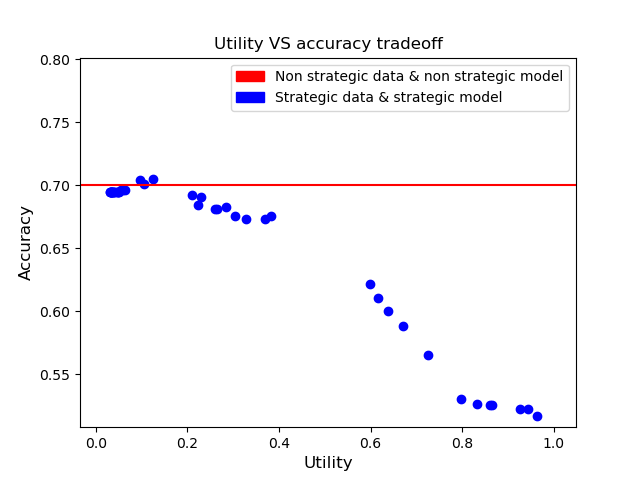

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


In [95]:
fig = plt.figure()
plt.rc('axes', titlesize=12)
plt.rc('axes', labelsize=12)
plt.title('Utility VS accuracy tradeoff')
plt.xlabel('Utility')
plt.ylabel('Accuracy')
ax = fig.add_subplot(111)
ax.scatter(utilities, accuracies, color='b')
plt.axhline(y=0.7, linestyle='-', color='r')

red_patch = mpatches.Patch(color='r', label='Non strategic data & non strategic model')
blue_patch = mpatches.Patch(color='b', label='Strategic data & strategic model')

plt.legend(handles=[red_patch, blue_patch])
plt.show()

# Test results

In [66]:
Xval_opt = non_strategic_model.optimize_X(Xval, evaluation=True)
print(non_strategic_model.evaluate(Xval, Yval))
print(strategic_model.evaluate(Xval, Yval))
print(non_strategic_model.evaluate(Xval_opt, Yval))
visualize_strategic_data(Xval, Xval_opt, Yval, non_strategic_model.w, non_strategic_model.b, strategic_model.w, strategic_model.b)



C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'non_strategic_model' is not defined

In [90]:
print(non_strategic_model.calc_utility(Xval, Xval_opt, True))

tensor(0.2228, grad_fn=<MeanBackward0>)
